In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib as plt

users = pd.read_excel('user_purchase_data.xlsx', sheet_name='user_registration')

mobile = pd.read_excel('user_purchase_data.xlsx', sheet_name='mobile_orders')


<Axes: >

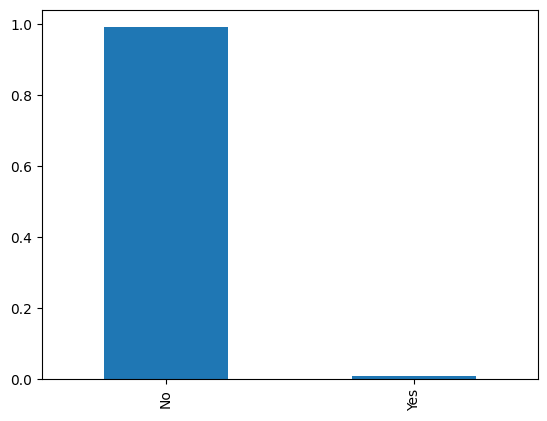

In [3]:
users['is_subscriber'].value_counts(dropna=False, normalize=True).plot(kind='bar')

<Axes: ylabel='Frequency'>

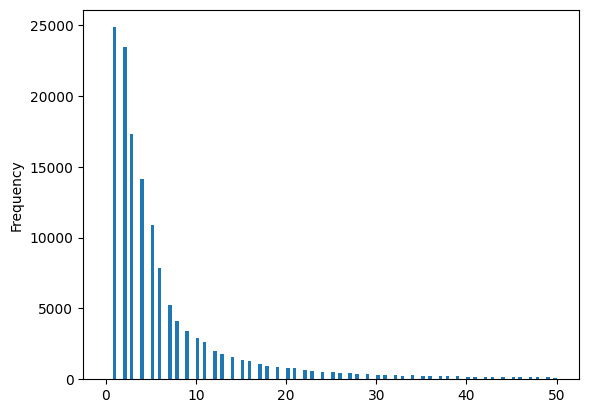

In [4]:
mobile['mobile_orders'].plot(kind='hist', bins=130, range=[0,50])

In [ ]:
mobile.loc[~mobile['user_id'].isin(users['userID']), 'user_id'].tolist()

In-store orders table

In [ ]:
in_store = pd.read_excel('user_purchase_data.xlsx', sheet_name='in_store_orders')
in_store.sample(15)

In [ ]:
in_store.dtypes

<Axes: ylabel='Frequency'>

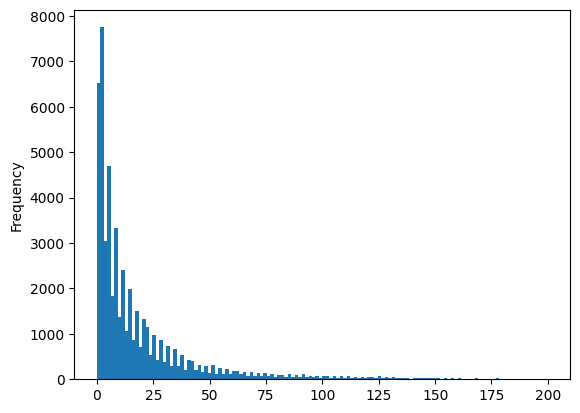

In [8]:
in_store['in_store_orders'].plot(kind='hist', bins = 130, range=[0,200])

In [ ]:
len(in_store.loc[~in_store['user_id'].isin(users['userID']), 'user_id'].tolist())

Data Frame Manipulation

In [10]:
users.rename(columns={'userID':'user_id'}, inplace=True)

In [11]:
users['user_category'] = ['Premium' if i=='Yes' else 'Free' for i in users['is_subscriber'].values]
users.drop(columns='is_subscriber', inplace=True)

In [12]:
orders = pd.merge(users, mobile, how='left', on='user_id').merge(in_store, how='left', on='user_id')

In [ ]:
orders.isna().sum()

In [ ]:
for col in orders.columns[2:]:
  orders[col] = orders[col].fillna(0)
orders.head()

In [ ]:
orders['total_orders'] = orders['mobile_orders'] + orders['in_store_orders']
orders['total_orders'] = orders['total_orders'].astype(int)
orders

In [16]:
orders.drop(columns=['mobile_orders', 'in_store_orders'], inplace=True)

In [ ]:
orders.total_orders.describe()

In [18]:
free='Free'
min_orders=50

100*orders[(orders['user_category']==free) & (orders['total_orders']>=min_orders)].shape[0]/(orders['user_category']==free).sum()

5.285198338951977

In [19]:
order_bins = [0,1,2,3,4,5,6,7,8,10,12,15,20,25,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,350,400,450,500,550,600,700,800,900,1000,1100]
len(order_bins)

43

In [ ]:
for order_bin in order_bins:
  orders['orders >= '+str(order_bin)] = [1 if i>=order_bin else 0 for i in orders['total_orders'].values]

orders

In [ ]:
pd.set_option('display.max_columns', None)
orders.head(10)

In [ ]:
totals = orders.drop(columns=['user_id', 'total_orders'])
totals.head()

In [ ]:
totals.columns[1:]

In [24]:
totals = totals.groupby('user_category')[totals.columns[1:]].sum().reset_index()

In [ ]:
totals

In [26]:
graph_df = pd.melt(totals,id_vars='user_category', value_vars=totals.columns[1:], var_name='orders_bin', value_name='registered_users')

In [ ]:
graph_df['min_orders'] = [int(i.split('>= ')[1]) for i in graph_df['orders_bin'].values]
graph_df.drop(columns='orders_bin', inplace=True)
graph_df

In [28]:
baseline = 1
graph_df['category_totals'] =\
[graph_df.loc[(graph_df['user_category']==i) & (graph_df['min_orders']==baseline), 'registered_users'].max() for i in graph_df['user_category']]

In [29]:
graph_df['%_registered_users'] = graph_df['registered_users']/graph_df['category_totals']

In [30]:
graph_df = graph_df.drop(columns=['registered_users', 'category_totals'])

Data Visuilzation

In [31]:
fig = go.Figure()
for i in graph_df['user_category'].unique():
  fig.add_trace(go.Scatter(x=graph_df.loc[graph_df['user_category'] ==i, 'min_orders'],
                          y=graph_df.loc[graph_df['user_category'] ==i, '%_registered_users'],
                          name = i+' Users',hovertemplate='<b>%{y:.2%}</b>'))


fig.update_traces(mode='markers+lines')
fig.update_layout(hovermode='x unified', xaxis_title='Minimum Total Orders',
                  yaxis={'title':'% of registered users who ordered ' + str(baseline)+'+ times', 'tickformat':',.0%'},
                  title={'text':'Retention Curve for Free vs. Premium Users', 'y':0.85,'x':0.47, 'xanchor':'center', 'yanchor':'middle'})

fig.update_xaxes(range=[baseline, 500])
fig.update_yaxes(range=[-0.01, 1.01])

fig.write_html('C:\\Users\\Cole\\Desktop\\customer_retention_curve.html')

fig.show()